# 6.2 Understanding recurrent neural networks

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that *they have no memory*. Each input shown to
them is processed independently, with no state kept in between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to
show the entire sequence to the network at once: turn it into a single data point. For
instance, this is what you did in the IMDB example: an entire movie review was transformed into a single large vector and processed in one go. Such networks are called
*feedforward networks*.

 In contrast, as you’re reading the present sentence, you’re processing it word by
word—or rather, eye saccade by eye saccade—while keeping memories of what came
before; this gives you a fluid representation of the meaning conveyed by this sentence.
Biological intelligence processes information incrementally while maintaining an
internal model of what it’s processing, built from past information and constantly
updated as new information comes in.

A **recurrent neural network** (RNN) adopts the same principle, albeit in an extremely
simplified version: it processes sequences by iterating through the sequence elements
and maintaining a state containing information relative
to what it has seen so far. In effect, an RNN is a type of
neural network that has an internal loop (see figure 6.9).
The state of the RNN is reset between processing two different, independent sequences (such as two different
IMDB reviews), so you still consider one sequence a single data point: a single input to the network. What
changes is that this data point is no longer processed in a
single step; rather, the network internally loops over
sequence elements.

 To make these notions of *loop* and *state* clear, let’s implement the forward pass of a
toy RNN in Numpy. This RNN takes as input a sequence of vectors, which you’ll encode
as a 2D tensor of size `(timesteps, input_features)`. It loops over timesteps, and at
each timestep, it considers its current state at `t` and the input at t (of shape `(input_
features,)`), and combines them to obtain the output at `t`. You’ll then set the state for
the next step to be this previous output. For the first timestep, the previous output
isn’t defined; hence, there is no current state. So, you’ll initialize the state as an allzero vector called the *initial state* of the network.

### *Pseudocode RNN*

In [ ]:
# The state at t
state_t = 0
# Iterates over sequence elements
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    # The previous output becomes the state for the next iteration
    state_t = output_t

You can even flesh out the function `f`: the transformation of the input and state into an
output will be parameterized by two matrices, `W` and `U`, and a bias vector. It’s similar to
the transformation operated by a densely connected layer in a feedforward network.

### *More detailed pseudocode for the RNN*

In [ ]:
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

### *Numpy implementation of a simple RNN*

In [ ]:
import numpy as np

# Number of timesteps in the input sequence
timesteps = 100
# Dimensionality of the input feature space and output feature space
input_features = 32
output_features = 64

# Input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))
# Initial state: an all-zero vector
state_t = np.zeros((output_features,))

# Create random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
# input_t is a vector of shape (input_features,).
for input_t in inputs:
    # Combines the input with the current state (the previous output) to obtain the current output
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # Stores this output in a list
    successive_outputs.append(output_t)
    # Updates the state of the network for the next timestep
    state_t = output_t

# The final output is a 2D tensor of shape (timesteps, output_features).
final_output_sequence = np.concatenate(successive_outputs, axis=0)

Easy enough: in summary, an RNN is a `for` loop that reuses quantities computed
during the previous iteration of the loop, nothing more. Of course, there are many
different RNNs fitting this definition that you could build—this example is one of the
simplest RNN formulations. RNNs are characterized by their step function, such as the
following function in this case:

`output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)`

<img src="https://drek4537l1klr.cloudfront.net/chollet/Figures/06fig10_alt.jpg" 
     align="center" 
     width="500" />
     
**Note**: In this example, the final output is a 2D tensor of shape `(timesteps,
output_features)`, where each timestep is the output of the loop at time `t`.
Each timestep `t` in the output tensor contains information about timesteps `0`
to `t` in the input sequence—about the entire past. For this reason, in many
cases, you don’t need this full sequence of outputs; you just need the last output (`output_t` at the end of the loop), because it already contains information about the entire sequence.

## 6.2.1 A recurrent layer in Keras

The process you just naively implemented in Numpy corresponds to an actual Keras
layer—the `SimpleRNN` layer. There is one minor difference: `SimpleRNN` processes batches of sequences, like all other
Keras layers, not a single sequence as in the Numpy example. This means it takes inputs
of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps,
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it
can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`) or only the last output for
each input sequence (a 2D tensor of shape `(batch_size, output_features)`). These
two modes are controlled by the return_sequences constructor argument. Let’s look
at an example that uses `SimpleRNN` and returns only the output at the last timestep:

In [1]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence:

In [2]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It’s sometimes useful to stack several recurrent layers one after the other in order to
increase the representational power of a network. In such a setup, you have to get all
of the intermediate layers to return full sequence of outputs:

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
# Last layer only returns the last output
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now, let’s use such a model on the IMDB movie-review-classification problem. First,
preprocess the data.

### *Preparing the IMDB data*

In [5]:
from keras.datasets import imdb
from keras.utils import pad_sequences

# Number of words to consider as features
max_features = 10000
# Cuts off texts after this many words (among the max_features most common words)
maxlen = 500
batch_size = 32

print('Loading data...')

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let’s train a simple recurrent network using an Embedding layer and a SimpleRNN
layer.

### *Training the model with `Embedding` and `SimpleRNN` layers*

In [6]:
from keras.layers import Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 17s 102ms/step - loss: 0.6391 - acc: 0.6139 - val_loss: 0.4890 - val_acc: 0.7890
Epoch 2/10
157/157 [==============================] - 15s 93ms/step - loss: 0.4101 - acc: 0.8246 - val_loss: 0.3758 - val_acc: 0.8442
Epoch 3/10
157/157 [==============================] - 16s 100ms/step - loss: 0.3004 - acc: 0.8798 - val_loss: 0.3670 - val_acc: 0.8572
Epoch 4/10
157/157 [==============================] - 16s 104ms/step - loss: 0.2368 - acc: 0.9089 - val_loss: 0.4386 - val_acc: 0.8324
Epoch 5/10
157/157 [==============================] - 17s 110ms/step - loss: 0.1889 - acc: 0.9286 - val_loss: 0.3850 - val_acc: 0.8642
Epoch 6/10
157/157 [==============================] - 15s 93ms/step - loss: 0.1578 - acc: 0.9413 - val_loss: 0.4468 - val_acc: 0.8102
Epoch 7/10
157/157 [==============================] - 15s 97ms/step - loss: 0.1110 - acc: 0.9621 - val_loss: 0.9513 - val_acc: 0.7504
Epoch 8/10
157/157 [==============================] - 15s 

### *Plotting results*

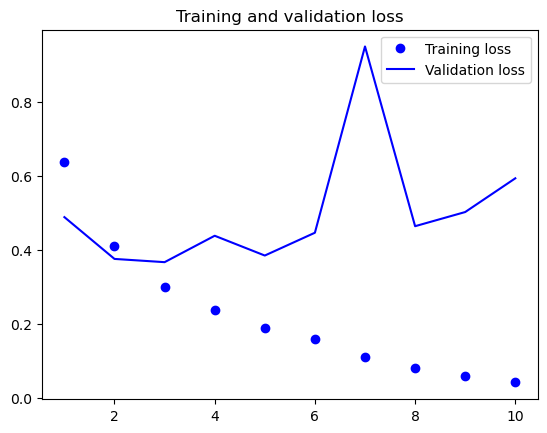

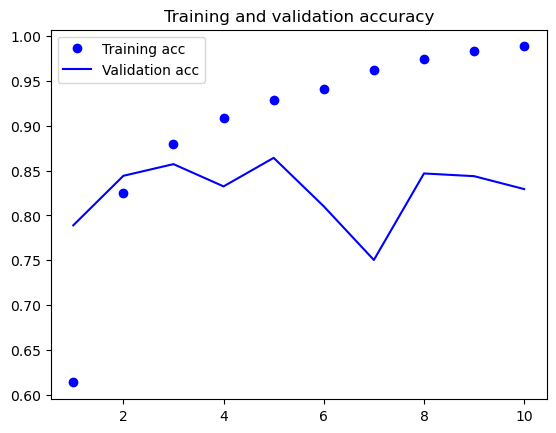

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

As a reminder, in chapter 3, the first naive approach to this dataset got you to a test
accuracy of 88%. Unfortunately, this small recurrent network doesn’t perform well
compared to this baseline (only 85% validation accuracy). Part of the problem is that
your inputs only consider the first 500 words, rather than full sequences—hence, the
RNN has access to less information than the earlier baseline model. The remainder of
the problem is that `SimpleRNN` isn’t good at processing long sequences, such as text.

Other types of recurrent layers perform much better. Let’s look at some moreadvanced layers. 

## 6.2.2 Understanding the LSTM and GRU layers

`SimpleRNN` isn’t the only recurrent layer available in Keras. There are two others: `LSTM`
and `GRU`. In practice, you’ll always use one of these, because `SimpleRNN` is generally too
simplistic to be of real use. `SimpleRNN` has a major issue: although it should theoretically
be able to retain at time `t` information about inputs seen many timesteps before, in
practice, such long-term dependencies are impossible to learn. This is due to the *vanishing gradient problem*, an effect that is similar to what is observed with non-recurrent
networks (feedforward networks) that are many layers deep: as you keep adding layers
to a network, the network eventually becomes untrainable. The theoretical reasons for
this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s (for example, Yoshua Bengio, Patrice Simard, and Paolo Frasconi, “Learning Long-Term Dependencies
with Gradient Descent Is Difficult,” IEEE Transactions on Neural Networks 5, no. 2 (1994)).
The *LSTM* and *GRU* layers are designed to solve this problem.

 Let’s consider the LSTM layer. The underlying Long Short-Term Memory (LSTM)
algorithm was developed by Hochreiter and Schmidhuber (Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997));
 it was the culmination of their research on the vanishing gradient problem.
 
 This layer is a variant of the `SimpleRNN` layer you already know about; it adds a way
to carry information across many timesteps. Imagine a conveyor belt running parallel
to the sequence you’re processing. Information from the sequence can jump onto the
conveyor belt at any point, be transported to a later timestep, and jump off, intact,
when you need it. This is essentially what LSTM does: it saves information for later,
thus preventing older signals from gradually vanishing during processing.

To understand this in detail, let’s start from the `SimpleRNN` cell.
Because you’ll have a lot of weight matrices, index the `W` and `U` matrices in the cell with
the letter `o` (`Wo` and `Uo`) for *output*.

<img src="https://drek4537l1klr.cloudfront.net/chollet/Figures/06fig13_alt.jpg"
     align='center'
     width=500
     />
     
Let’s add to this picture an additional data flow that carries information across timesteps. Call its values at different timesteps `Ct`, where C stands for *carry*. This information will have the following impact on the cell: it will be combined with the input
connection and the recurrent connection (via a dense transformation: a dot product
with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep (via an activation
function an a multiplication operation). Conceptually, the carry dataflow is a way to
modulate the next output and the next state. Simple so far.

<img src='https://drek4537l1klr.cloudfront.net/chollet/Figures/06fig14_alt.jpg'
     align='center'
     width=500
     />
     
Now the subtlety: the way the next value of the carry dataflow is computed. It involves
three distinct transformations. All three have the form of a SimpleRNN cell:

`y = activation(dot(state_t, U) + dot(input_t, W) + b)`

But all three transformations have their own weight matrices, which you’ll index with
the letters `i`, `f`, and `k`. Here’s what you have so far (it may seem a bit arbitrary, but bear
with me).

### *Pseudocode details of the LSTM architecture*

In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

# Obtains the new carry state (the next c_t) by combining i_t, f_t, and k_t.
c_t+1 = i_t * k_t + c_t * f_t

<img src='https://drek4537l1klr.cloudfront.net/chollet/Figures/06fig15_alt.jpg'
     align='center'
     width=500
     />
     
If you want to get philosophical, you can interpret what each of these operations is
meant to do. For instance, you can say that multiplying `c_t` and `f_t` is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, `i_t` and `k_t` provide information about the present, updating the carry track with new information.
But at the end of the day, these interpretations don’t mean much, because what these
operations actually do is determined by the contents of the weights parameterizing
them; and the weights are learned in an end-to-end fashion, starting over with each
training round, making it impossible to credit this or that operation with a specific
purpose. The specification of an RNN cell (as just described) determines your hypothesis space—the space in which you’ll search for a good model configuration during
training—but it doesn’t determine what the cell does; that is up to the cell weights.
The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints
on your search, not as a design in an engineering sense.

 To a researcher, it seems that the choice of such constraints—the question of how to
implement RNN cells—is better left to optimization algorithms (like genetic algorithms
or reinforcement learning processes) than to human engineers. And in the future,
that’s how we’ll build networks. In summary: you don’t need to understand anything
about the specific architecture of an `LSTM` cell; as a human, it shouldn’t be your job to
understand it. Just keep in mind what the `LSTM` cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem. 


## 6.2.3 A concrete LSTM example in Keras

Now let’s switch to more practical concerns: you’ll set up a model using an `LSTM` layer
and train it on the IMDB data. The network is similar to the
one with `SimpleRNN` that was just presented. You only specify the output dimensionality of the `LSTM` layer; leave every other argument (there are many) at the Keras defaults. Keras has good defaults, and things will almost always “just work” without you
having to spend time tuning parameters by hand.

### *Using the `LSTM` layer in Keras*

In [9]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 45s 277ms/step - loss: 0.5952 - acc: 0.6759 - val_loss: 0.4398 - val_acc: 0.8112
Epoch 2/10
157/157 [==============================] - 44s 282ms/step - loss: 0.3538 - acc: 0.8555 - val_loss: 0.4670 - val_acc: 0.8266
Epoch 3/10
157/157 [==============================] - 44s 280ms/step - loss: 0.2685 - acc: 0.8942 - val_loss: 0.3538 - val_acc: 0.8766
Epoch 4/10
157/157 [==============================] - 44s 280ms/step - loss: 0.2300 - acc: 0.9128 - val_loss: 0.3092 - val_acc: 0.8768
Epoch 5/10
157/157 [==============================] - 44s 281ms/step - loss: 0.2029 - acc: 0.9263 - val_loss: 0.2976 - val_acc: 0.8774
Epoch 6/10
157/157 [==============================] - 44s 279ms/step - loss: 0.1763 - acc: 0.9377 - val_loss: 0.3221 - val_acc: 0.8812
Epoch 7/10
157/157 [==============================] - 42s 266ms/step - loss: 0.1625 - acc: 0.9420 - val_loss: 0.6827 - val_acc: 0.8202
Epoch 8/10
157/157 [==============================] - 4

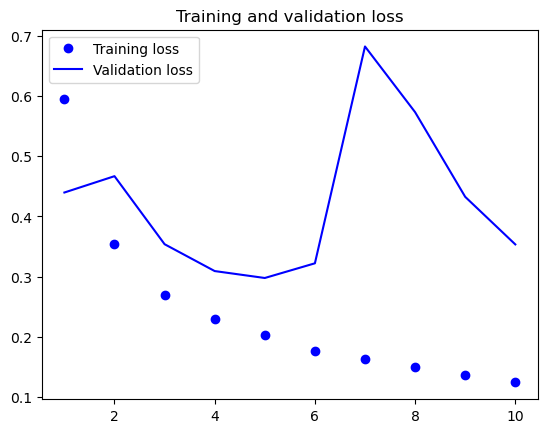

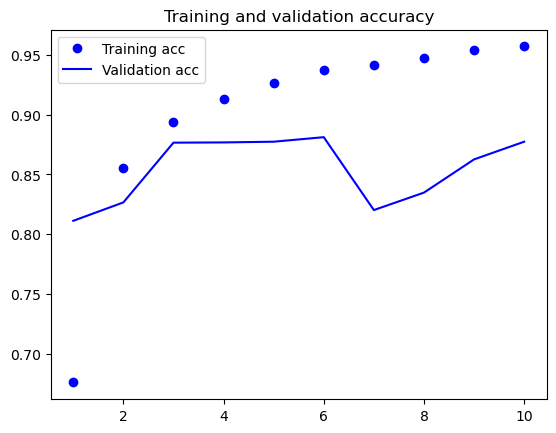

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

This time, you achieve up to 88% validation accuracy. Not bad: certainly much better
than the `SimpleRNN` network—that’s largely because LSTM suffers much less from the
vanishing-gradient problem—and slightly better than the fully connected approach
from chapter 3, even though you’re looking at less data than you were in chapter 3.
You’re truncating sequences after 500 timesteps, whereas in chapter 3, you were considering full sequences.

 But this result isn’t groundbreaking for such a computationally intensive
approach. Why isn’t LSTM performing better? One reason is that you made no effort
to tune hyperparameters such as the embeddings dimensionality or the LSTM output
dimensionality. Another may be lack of regularization. But honestly, the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good
at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved
by looking at what words occur in each review, and at what frequency. That’s what the
first fully connected approach looked at. But there are far more difficult naturallanguage-processing problems out there, where the strength of LSTM will become
apparent: in particular, question-answering and machine translation.

## 6.2.4 Wrapping up

Now you understand the following:
- What RNNs are and how they work
- What LSTM is, and why it works better on long sequences than a naive RNN
- How to use Keras RNN layers to process sequence data
Next, we’ll review a number of more advanced features of RNNs, which can help you
get the most out of your deep-learning sequence models. 